# MSP Italy - Flat Data Model Exporter

In [2]:
## How intall geoserver-rest
# export CPLUS_INCLUDE_PATH=/usr/include/gdal
# export C_INCLUDE_PATH=/usr/include/gdal
# pip install GDAL==1.11.2
# pip install pygdal=="`gdal-config --version`.*"
# pip install geoserver-rest

%matplotlib inline

from PIL import Image, ImageDraw, ImageFont
import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import png
from geo.Geoserver import Geoserver
geo = Geoserver('http://data.tools4msp.eu/geoserver', username='mspitaly_admin', password='Ciuppaluppa')

#from utils import use_codes_list, dfuses #leggo direttamente dal db

In [3]:
source = "data/planning.gpkg"
for layername in fiona.listlayers(source):
    with fiona.open(source, layer=layername) as src:
        print(layername, len(src))

eu_contries 37
uses_pu 4169
regioni_istat 20
land_EEA_2018 27
areas 3
subareas 27
planning_units 327
pu_uses 14
pu_type 4


In [5]:
msp_areas = gpd.read_file(source, layer="areas")
msp_subareas = gpd.read_file(source, layer="subareas")
planning_units = gpd.read_file(source, layer="planning_units")
pu_uses = gpd.read_file(source, layer="pu_uses").set_index("code")
use_codes_list = pu_uses.index.tolist()


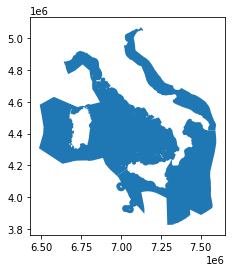

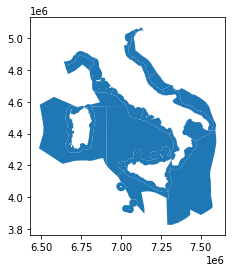

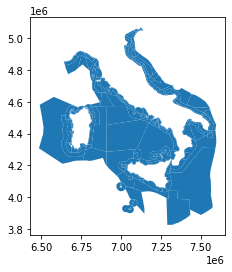

In [6]:
msp_areas.plot()
msp_subareas.plot()
planning_units.plot()
cols = ['codice', 'denomin', 'geometry']
msp_areas = msp_areas.rename(columns={'area': 'codice', 'name': 'denomin'})[cols].reset_index()
msp_areas.to_file("outputs/msp_italy_flat_areas_v1.shp")
cols = ['codice', 'tipo', 'geometry']
msp_subareas = msp_subareas.rename(columns={'subarea': 'codice', 'name': 'tipo'})[cols].reset_index()
msp_subareas.to_file("outputs/msp_italy_flat_subareas_v1.shp")
pu_uses.to_csv("outputs/pu_uses.csv")


In [7]:
# clean u_p and u_a and tipo, and set zfill
def clean_u_column(col):
    return col.fillna("").str.replace(" ","").str.split(',').apply(list).apply(lambda x: ",".join(np.sort(np.char.zfill(np.array(x).astype(str), 4))))

zoning_elements = planning_units.copy()
zoning_elements.rename(columns={'Code': 'codice', 'Type': 'tipo', 'main_uses': 'u_p', 'other_uses': 'u_a', 'area_km_GRS80': 'kmq'}, inplace=True)

# zoning_elements['orig_u_p'] = zoning_elements.u_p
# zoning_elements['orig_u_a'] = zoning_elements.u_a

zoning_elements.u_p = clean_u_column(zoning_elements.u_p)
zoning_elements.u_a = clean_u_column(zoning_elements.u_a)
zoning_elements.tipo = zoning_elements.tipo.str.replace('\(.*\)', '').str.strip()



In [8]:
# check a specific PU
df = planning_units.query("Code=='MO/3_14'")
df.label.item()


'MO/3_14 | P(tm)'

In [9]:
# check invalid uses
_uses_p = zoning_elements.u_p.str.split(',', expand=True).fillna('0000').melt().value.sort_values().unique()
_uses_a = zoning_elements.u_a.str.split(',', expand=True).fillna('0000').melt().value.sort_values().unique()

diff_uses_p = set(_uses_p) - set(use_codes_list) - set(['0000'])
diff_uses_a = set(_uses_a) - set(use_codes_list) - set(['0000'])
if len(diff_uses_p) > 0:
    print("WARNING Invalid uses in u_p", diff_uses_p)
if len(diff_uses_a) > 0:
    print("WARNING Invalid uses in u_a", diff_uses_a)

In [10]:
# Check invalid uses by PU
for idx, r in zoning_elements.iterrows():
    invalid_u_p = []
    invalid_u_a = []
    isok = True
    for code in r.u_p.split(','):
        if code != '0000' and  code not in use_codes_list:
            invalid_u_p.append(code)
            isok = False
    for code in r.u_a.split(','):
        if code != '0000' and code not in use_codes_list:
            invalid_u_a.append(code)
            isok = False
    if not isok:
        print("PU", r.codice)
        if len(invalid_u_p) > 0:
            print("\t invalid u_p", invalid_u_p)
        if len(invalid_u_a) > 0:
            print("\t invalid u_a", invalid_u_a)

In [11]:
# add missing u_a

#for idx, r in zoning_elements.iterrows():
#    zoning_elements.at[idx, 'u_a'] = ",".join(np.setdiff1d(use_codes_list, r.u_p.split(',')))
zoning_elements.head()

,id,codice,tipo,pu_type,lbl_x,lbl_y,pu_types,label,u_p,u_a,num_rel,location,area_km,subarea,note,geometry
0,1.0,A/3_01,P,200,6.994330e+06,4.956858e+06,Prioritary,A/3_01 | P(t),0700,"0100,0200,0300,0400,0500,0600,0900,1000,1100,1...",None,acque terr,59.02,A/3,"Altri usi citati nel piano: Pesca,Trasporto ma...","MULTIPOLYGON (((7023412.570 4941571.750, 70201..."
1,2.0,A/3_02,P,200,7.029833e+06,4.949362e+06,Prioritary,A/3_02 | P(a),1500,"0100,0200,0300,0400,0500,0600,0700,0900,1000,1...",None,acque terr,115.13,A/3,"Altri usi citati nel piano: Pesca,Trasporto ma...","MULTIPOLYGON (((7025074.508 4954529.347, 70251..."
2,4.0,A/3_04,P,200,7.039380e+06,4.937726e+06,Prioritary,"A/3_04 | P(n,d)","0300,0600","0100,0200,0400,0500,0700,0900,1000,1100,1200,1...",None,acque terr,305.39,A/3,"Altri usi citati nel piano: Pesca,Trasporto ma...","MULTIPOLYGON (((7052426.141 4944327.128, 70523..."
3,5.0,A/3_05,P,200,7.043798e+06,4.859833e+06,Prioritary,A/3_05 | P(t),0700,"0100,0200,0300,0400,0500,0600,0900,1000,1100,1...",None,acque terr,295.67,A/3,"Altri usi citati nel piano: Pesca,Trasporto ma...","MULTIPOLYGON (((7060232.056 4863396.003, 70602..."
4,9.0,A/3_09,L,300,7.047864e+06,4.912839e+06,Limited,A/3_09 | L(n),0300,"0700,1000,1200,1300,1400",None,acque terr,0.71,A/3,Altri usi citati nel piano: Turismo,"MULTIPOLYGON (((7046153.823 4908877.907, 70458..."


In [12]:
dfuses = pu_uses[[ 'use_ita', 'label', 'color', 'use_ita_short', 'sld_style']]
#use_code_list=dfuses["code"].tolist()
dfuses

,use_ita,label,color,use_ita_short,sld_style
code,,,,,
0100,Pesca,p,#F4AAAE,Pesca,zoning_elements_pesca.sld
1500,Acquacoltura,a,#B9829F,Acquacoltura,zoning_elements_acquacoltura.sld
0200,Trasporto marittimo e portualità,tm,#6E7C97,Trasporto mar. portualità,zoning_elements_trasporto.sld
0300,Protezione ambiente e risorse naturali,n,#88BC91,Protez. ambiente e ris.naturali,zoning_elements_protezione.sld
0400,Energia,e,#C04B4B,Energia,zoning_elements_energia.sld
0500,Prelievo di sabbie,sa,#FCD154,Sabbie,zoning_elements_sabbie.sld
0600,Difesa,d,#CCAE99,Difesa,zoning_elements_difesa.sld
0700,Turismo costiero e marittimo,t,#F4A166,Turismo,zoning_elements_turismo.sld
1000,Paesaggio e Patrimonio Culturale,ppc,#778775,Paesaggio e Patrimonio Cult.,zoning_elements_paesaggio.sld


In [13]:
# prepare use strings
zoning_elements['u_p_txt'] = zoning_elements.u_p.str.split(',').apply(lambda x: [dfuses.at[y, 'use_ita_short'] for y in x if y != '0000']).str.join(', ')
zoning_elements['u_a_txt'] = zoning_elements.u_a.str.split(',').apply(lambda x: [dfuses.at[y, 'use_ita_short'] for y in x if y != '0000']).str.join(', ')

zoning_elements['subarea'] = zoning_elements.codice.str.replace('_\d+', '')
cols = ['subarea','codice','tipo','u_p','u_p_txt','u_a','u_a_txt', 'area_km','note', 'label','geometry']
zoning_elements = zoning_elements[cols].reset_index().rename(columns={'index': 'id'}).copy()
#zoning_elements['note'] = ''
zoning_elements.to_file("outputs/msp_italy_flat_zoning_elements_v1.shp")

In [14]:
# check if there are list longer than shapefile capacity
lunghi = zoning_elements.query("u_a_txt.str.len()> 255")
lunghi.shape

(0, 12)

In [15]:
def draw_class_image(classes, class_height=7):
    height = class_height * len(classes)
    img = Image.new('RGB', (20, height), color = "#ffffff")
    d = ImageDraw.Draw(img)
    x0, y0, x1, y1 = 0, 0, 20, 10
    for c in classes:
        color = dfuses.at[c, 'color']
        print(color, c)
        d.rectangle([x0, y0, x1, y1], fill=color, outline=None, width=0)
        y0 += class_height
        y1 += class_height
    fname = 'leg_{}.png'.format("_".join([str(c).zfill(4) for c in classes]))
    img.save("outputs/" + fname)
    return fname, height
# draw_class_image([100, 200, 300, 400])

In [16]:
SDLLABEL = """
<sld:TextSymbolizer>
  <sld:Label>
    <ogc:PropertyName>label</ogc:PropertyName>
  </sld:Label>
</sld:TextSymbolizer>
"""

SLDBASE = """<?xml version="1.0" encoding="UTF-8"?>
<sld:StyledLayerDescriptor xmlns="http://www.opengis.net/sld" xmlns:sld="http://www.opengis.net/sld" xmlns:ogc="http://www.opengis.net/ogc" xmlns:gml="http://www.opengis.net/gml" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.0.0">
  <sld:NamedLayer>
    <sld:Name>zoning_elements</sld:Name>
    <sld:UserStyle>
      <sld:Name>zoning_elements</sld:Name>
      <sld:Title>zoning_elements</sld:Title>
      <sld:FeatureTypeStyle>
        <sld:Name>name</sld:Name>
        {rules}
      </sld:FeatureTypeStyle>
    </sld:UserStyle>
  </sld:NamedLayer>
</sld:StyledLayerDescriptor>
"""

SLDRULE = """
<sld:Rule>
  <Name>{name}</Name>
  <Title>{title}</Title>
  <ogc:Filter>
    <ogc:PropertyIsEqualTo>
      <ogc:PropertyName>u_p</ogc:PropertyName>
      <ogc:Literal>{code}</ogc:Literal>
    </ogc:PropertyIsEqualTo>
  </ogc:Filter>
  <sld:PolygonSymbolizer>
    <sld:Fill>
      {fill}
      </sld:Fill>
      <sld:Stroke>
        <sld:CssParameter name="stroke">#777777</sld:CssParameter>
        <sld:CssParameter name="stroke-width">0.7</sld:CssParameter>
      </sld:Stroke>
  </sld:PolygonSymbolizer>
  {label}
</sld:Rule>
"""

SLDFILLCOLOR = '<sld:CssParameter name="fill">{color}</sld:CssParameter>'

SLDFILLGRAPH = """
      <sld:GraphicFill>
        <sld:Graphic>
          <sld:ExternalGraphic>
            <sld:OnlineResource xlink:type="simple" xlink:href="{image_name}" />
            <sld:Format>image/png</sld:Format>
          </sld:ExternalGraphic>
          <sld:Size>{image_height}</sld:Size>
        </sld:Graphic>
      </sld:GraphicFill>
"""

SLDRULEGENERIC = """
<sld:Rule>
  <Name>generico</Name>
  <Title>Generico</Title>
  <ogc:Filter>
    <ogc:PropertyIsEqualTo>
      <ogc:PropertyName>tipo</ogc:PropertyName>
      <ogc:Literal>G</ogc:Literal>
    </ogc:PropertyIsEqualTo>
  </ogc:Filter>
  <sld:PolygonSymbolizer>
    <sld:Fill>
      <sld:CssParameter name="fill">#e3e3e2</sld:CssParameter>
      </sld:Fill>
      <sld:Stroke>
        <sld:CssParameter name="stroke">#777777</sld:CssParameter>
        <sld:CssParameter name="stroke-width">0.7</sld:CssParameter>
      </sld:Stroke>
  </sld:PolygonSymbolizer>
  {label}
</sld:Rule>
"""

SLDSINGLEUSE = """<?xml version="1.0" encoding="UTF-8"?>
<sld:StyledLayerDescriptor xmlns="http://www.opengis.net/sld" xmlns:sld="http://www.opengis.net/sld" xmlns:ogc="http://www.opengis.net/ogc" xmlns:gml="http://www.opengis.net/gml" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.0.0">
  <sld:NamedLayer>
    <sld:Name>{use_sld_name}</sld:Name>
    <sld:UserStyle>
      <sld:Name>{use_sld_name}</sld:Name>
      <sld:Title>{use_sld_name}</sld:Title>
      <sld:FeatureTypeStyle>
        <sld:Name>name</sld:Name>

<sld:Rule>
  <Name>prioritario</Name>
  <Title>Riservato, limitato, prioritario</Title>
  <ogc:Filter>
    <ogc:PropertyIsLike  wildCard="*" singleChar="." escape="#">
      <ogc:PropertyName>u_p</ogc:PropertyName>
      <ogc:Literal>*{use_sld_code}*</ogc:Literal>
    </ogc:PropertyIsLike>
  </ogc:Filter>
  <sld:PolygonSymbolizer>
    <sld:Fill>
      <sld:CssParameter name="fill">{use_sld_color}</sld:CssParameter>
    </sld:Fill>
      <sld:Stroke>
        <sld:CssParameter name="stroke">#777777</sld:CssParameter>
        <sld:CssParameter name="stroke-width">0.7</sld:CssParameter>
      </sld:Stroke>
  </sld:PolygonSymbolizer>
</sld:Rule>
        
<sld:Rule>
  <Name>altro_uso</Name>
  <Title>Aree consentite salvo fattibilità o diverse 
specifiche limitazioni e regolamentazioni</Title>
  <ogc:Filter>
    <ogc:PropertyIsLike  wildCard="*" singleChar="." escape="#">
      <ogc:PropertyName>u_a</ogc:PropertyName>
      <ogc:Literal>*{use_sld_code}*</ogc:Literal>
    </ogc:PropertyIsLike>
  </ogc:Filter>
  <sld:PolygonSymbolizer>
    <sld:Fill>
           <GraphicFill>
             <Graphic>
               <Mark>
                 <WellKnownName>x</WellKnownName>
                 <Stroke>
                   <CssParameter name="stroke">{use_sld_color}</CssParameter>
                   <CssParameter name="stroke-width">1</CssParameter>
                 </Stroke>
               </Mark>
               <Size>10</Size>
             </Graphic>
           </GraphicFill>
    </sld:Fill>
      <sld:Stroke>
        <sld:CssParameter name="stroke">#777777</sld:CssParameter>
        <sld:CssParameter name="stroke-width">0.7</sld:CssParameter>
      </sld:Stroke>
  </sld:PolygonSymbolizer>
</sld:Rule>
        
      </sld:FeatureTypeStyle>
    </sld:UserStyle>
  </sld:NamedLayer>
</sld:StyledLayerDescriptor>
"""

In [17]:
print(SLDBASE)

<?xml version="1.0" encoding="UTF-8"?>
<sld:StyledLayerDescriptor xmlns="http://www.opengis.net/sld" xmlns:sld="http://www.opengis.net/sld" xmlns:ogc="http://www.opengis.net/ogc" xmlns:gml="http://www.opengis.net/gml" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.0.0">
  <sld:NamedLayer>
    <sld:Name>zoning_elements</sld:Name>
    <sld:UserStyle>
      <sld:Name>zoning_elements</sld:Name>
      <sld:Title>zoning_elements</sld:Title>
      <sld:FeatureTypeStyle>
        <sld:Name>name</sld:Name>
        {rules}
      </sld:FeatureTypeStyle>
    </sld:UserStyle>
  </sld:NamedLayer>
</sld:StyledLayerDescriptor>



In [18]:
# [dfuses.at[c, 'use_ita'] for c in classes]

In [19]:
rules = []
for idx, row in dfuses.iterrows():
    if row.color != '' and row.color != '#':
        code = str(idx).zfill(4)
        print(code, row.use_ita)
        fill = SLDFILLCOLOR.format(color=row.color)
        rule = SLDRULE.format(name=row.label, title=row.use_ita, code=code, fill=fill, label=SDLLABEL)
        rules.append(rule)
rules.append(SLDRULEGENERIC.format(label=SDLLABEL))
for graphlab in zoning_elements[zoning_elements.u_p.str.contains(',')].u_p.unique():
    classes = [c for c in graphlab.split(',')]
    print(classes)
    fname, height = draw_class_image(classes)
    fill = SLDFILLGRAPH.format(image_name="zoning_elements_png/" + fname, image_height=height)
    name = ", ".join([dfuses.at[c, 'label'] for c in classes])
    title = ", ".join([dfuses.at[c, 'label'] for c in classes])
    rule = SLDRULE.format(name=title, title=title, code=graphlab, fill=fill, label=SDLLABEL)
    rules.append(rule)
style = SLDBASE.format(rules="\n".join(rules))
# print(style)
f = open('outputs/zoning_elements.sld', 'w')
f.write(style)
f.close()
geo.upload_style(path=f'outputs/zoning_elements.sld')


0100 Pesca
1500 Acquacoltura
0200 Trasporto marittimo e portualità
0300 Protezione ambiente e risorse naturali
0400 Energia
0500 Prelievo di sabbie
0600 Difesa
0700 Turismo costiero e marittimo
1000 Paesaggio e Patrimonio Culturale
1400 Ricerca scientifica e innovazione
1300 Sicurezza marittima, della navigazione e sorveglianza
1200 Difesa costiera, protezione dalle alluvioni, ripristino della morfologia dei fondali
1100 Immersione sedimenti dragati
0900 Telecomunicazioni
['0300', '0600']
#88BC91 0300
#CCAE99 0600
['0300', '0700', '1500']
#88BC91 0300
#F4A166 0700
#B9829F 1500
['0200', '0400']
#6E7C97 0200
#C04B4B 0400
['0200', '0300']
#6E7C97 0200
#88BC91 0300
['0700', '1000']
#F4A166 0700
#778775 1000
['0300', '0700']
#88BC91 0300
#F4A166 0700
['0100', '0700']
#F4AAAE 0100
#F4A166 0700
['0300', '0700', '1000']
#88BC91 0300
#F4A166 0700
#778775 1000
['0100', '0300', '0700', '1000']
#F4AAAE 0100
#88BC91 0300
#F4A166 0700
#778775 1000
['0200', '0300', '0700', '1000']
#6E7C97 0200
#88BC9

'401: Style file can not be uploaded! b\'<html><head><title>Apache Tomcat/7.0.52 (Ubuntu) - Error report</title><style><!--H1 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:22px;} H2 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:16px;} H3 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:14px;} BODY {font-family:Tahoma,Arial,sans-serif;color:black;background-color:white;} B {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;} P {font-family:Tahoma,Arial,sans-serif;background:white;color:black;font-size:12px;}A {color : black;}A.name {color : black;}HR {color : #525D76;}--></style> </head><body><h1>HTTP Status 401 - Communication with GeoNode failed (UsernamePasswordAuthenticationToken)</h1><HR size="1" noshade="noshade"><p><b>type</b> Status report</p><p><b>message</b> <u>Communication with GeoNode failed (UsernamePasswordAuthenticationToken)</u></p><p><b>

In [25]:
# generate single  styles
# dfuses = pu_uses[[ 'use_ita', 'label', 'color', 'use_ita_short', 'sld_style']]
for i,u in dfuses.iterrows():
    if u['sld_style'] != '':
        use_sld_name = u['sld_style'].replace( '.sld', '')
        use_sld_code = i
        use_sld_color = u['color']
        filepath = f'outputs/{use_sld_name}.sld'
        use_style = SLDSINGLEUSE.format(use_sld_name=use_sld_name,
                                    use_sld_code=use_sld_code,
                                    use_sld_color=use_sld_color)
        # print(use_style)
        f = open(filepath, 'w')
        f.write(use_style)
        f.close()
        # upload styles
        geo.upload_style(path=f'outputs/{use_sld_name}.sld')


# use_sld_name = "zoning_elements_pesca"
# use_sld_code = "0100"
# use_sld_color = "#F4AAAE"


In [26]:
print(style)

<?xml version="1.0" encoding="UTF-8"?>
<sld:StyledLayerDescriptor xmlns="http://www.opengis.net/sld" xmlns:sld="http://www.opengis.net/sld" xmlns:ogc="http://www.opengis.net/ogc" xmlns:gml="http://www.opengis.net/gml" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.0.0">
  <sld:NamedLayer>
    <sld:Name>zoning_elements</sld:Name>
    <sld:UserStyle>
      <sld:Name>zoning_elements</sld:Name>
      <sld:Title>zoning_elements</sld:Title>
      <sld:FeatureTypeStyle>
        <sld:Name>name</sld:Name>
        
<sld:Rule>
  <Name>p</Name>
  <Title>Pesca</Title>
  <ogc:Filter>
    <ogc:PropertyIsEqualTo>
      <ogc:PropertyName>u_p</ogc:PropertyName>
      <ogc:Literal>0100</ogc:Literal>
    </ogc:PropertyIsEqualTo>
  </ogc:Filter>
  <sld:PolygonSymbolizer>
    <sld:Fill>
      <sld:CssParameter name="fill">#F4AAAE</sld:CssParameter>
      </sld:Fill>
      <sld:Stroke>
        <sld:CssParameter name="stroke">#777777</sld:CssParameter>
        <sld:CssParameter name="stroke-width">0.7<